 # 5 2-D Anisotropic Diffusion, non coercive case
 
 In this tutorial, we consider the study and analysis of the eigenvalue problem associated to the following anisotropic diffusion operator
$$
    - \nabla \cdot \mathbf{b} \otimes \mathbf{b} \nabla \phi = \omega^2 \phi
$$
where $\mathbf{b} = (\iota, 1)$ is the normalized vector of the magnetic field.

In fact, the original problem is 3D and the iota profile is given as

$$
    \iota(r) = 0.47262 + 0.32392 r + 0.49604 r^2 + 5.3991 . 10^{-6} r^3 - 3.165 . 10^{-5} r^4 + 4.7963 . 10^{-5} r^5 - 2.2824 . 10^{-5} r^6
$$

which is the LHD-$\iota$-profile. 

## Constants coefficients case

Now taking the given radius $r = 0.9$ we get

$$
\mathbf{b} = (b_1,b_2)^\top = (1.1659397624413860850012270020670, 1. )^\top
$$


In [1]:
from numpy import linspace, meshgrid, zeros, pi

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Math

from sympy.core.containers import Tuple
from sympy import symbols
from sympy import Symbol
from sympy import Lambda
from sympy import Function
from sympy import IndexedBase

from gelato.glt import glt_symbol
from gelato.glt import glt_lambdify
from gelato.glt import glt_approximate_eigenvalues
from gelato.printing.latex import glt_latex
from gelato.calculus   import (Dot, Cross, Grad, Curl, Rot, Div, dx, dy)
from gelato.calculus   import Constant
from gelato.fem.assembly import assemble_matrix
from gelato.fem.utils    import compile_kernel
from gelato.fem.utils    import compile_symbol

from spl.fem.splines import SplineSpace
from spl.fem.tensor  import TensorSpace

In [2]:
x,y = symbols('x y')

u = Symbol('u')
v = Symbol('v')

b1 = Constant('b1')
b2 = Constant('b2')
b = Tuple(b1, b2)

a = Lambda((x,y,v,u), Dot(b, Grad(v)) * Dot(b, Grad(u)))


In [3]:
# ...  create a finite element space
p1  = 3 ; p2  = 3
ne1 = 16 ; ne2 = 16

grid_1 = linspace(0., 1., ne1+1)
grid_2 = linspace(0., 1., ne2+1)

V1 = SplineSpace(p1, grid=grid_1)
V2 = SplineSpace(p2, grid=grid_2)

V = TensorSpace(V1, V2)
# ...

In [4]:
a_m = Lambda((x,y,v,u), v * u)
kernel_m_f90 = compile_kernel('kernel_m', a_m, V,
                            backend='fortran')

In [5]:
Mass = assemble_matrix(V, kernel_m_f90).tocsr()

In [6]:
symbol_m = compile_symbol('symbol_m', a_m, V,
                          backend='fortran')

In [7]:
d_constants = {'b2': 1.}
d_types = {'b1': 'double'}

In [8]:
kernel_a_f90 = compile_kernel('kernel_1', a, V,
                            d_constants=d_constants,
                            d_args=d_types,
                            backend='fortran')

In [9]:
d_args = {'b1': 1.165939762441386085001227002067}

In [10]:
M = assemble_matrix(V, kernel_a_f90, args=d_args).tocsr()

In [11]:
# import eigenvalue solver
from scipy.linalg import eig, inv

M = M.todense()
Mass = Mass.todense()
M = M * inv(Mass)
w, v = eig(M)
wr = w.real
wr.sort()

In [12]:
symbol = glt_symbol(a, space=V, evaluate=False)


In [13]:
symbol_a = compile_symbol('symbol_a', a, V,
                          d_constants=d_constants,
                          d_args=d_types,
                          backend='fortran')

In [14]:
# ... example of symbol evaluation
[n1,n2] = [W.nbasis for W in V.spaces]

t1 = linspace(-pi,pi, n1)
t2 = linspace(-pi,pi, n2)
x1 = linspace(0.,1., n1)
x2 = linspace(0.,1., n2)
e_a = zeros((n1, n2), order='F')
e_m = zeros((n1, n2), order='F')
symbol_a(x1,x2,t1,t2, e_a, d_args['b1'])
symbol_m(x1,x2,t1,t2, e_m)
e = e_a/e_m
t = e.ravel()
t.sort()
# ...

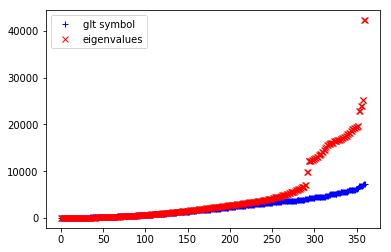

In [15]:
plt.plot(t, "+b", label="glt symbol")
plt.plot(wr, "xr", label="eigenvalues")
plt.legend(loc=2);

In [16]:
# ... compute the symbol f_a / f_m
def plot_symbol(nx, ny):
    
    t1 = linspace(-pi,pi, nx)
    t2 = linspace(-pi,pi, ny)
    x1 = linspace(0.,1., nx)
    x2 = linspace(0.,1., ny)
    e_a = zeros((nx, ny), order='F')
    e_m = zeros((nx, ny), order='F')
    symbol_a(x1,x2,t1,t2, e_a, d_args['b1'])
    symbol_m(x1,x2,t1,t2, e_m)
    e = e_a/e_m
    e = e / (4 * pi**2)
    
    T1,T2 = meshgrid(t1,t2)
    plt.contourf(T1, T2, e)
    plt.axis("equal")
# ...

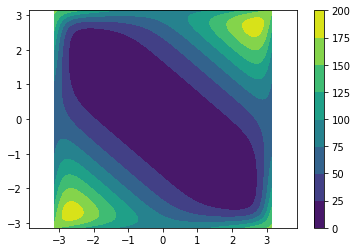

In [17]:
# ... plot
plot_symbol(100, 100)
plt.colorbar();
# ...

In [20]:
_b1 = d_args['b1']
_b2 = d_constants['b2']

n = range(-ne1//2, ne1//2+1) 
m = range(-ne2//2, ne2//2+1)
n,m = meshgrid(n,m)
n = n.transpose()
m = m.transpose()
f = (_b1*n + _b2*m)**2 

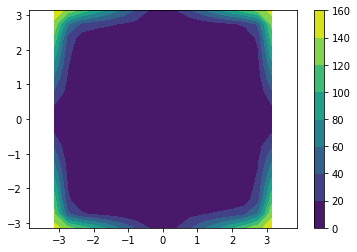

In [21]:
nx = ne1+1 ; ny = ne2+1
t1 = linspace(-pi,pi, nx)
t2 = linspace(-pi,pi, ny)

x1 = linspace(0.,1., nx)
x2 = linspace(0.,1., ny)
e_a = zeros((nx, ny), order='F')
e_m = zeros((nx, ny), order='F')
symbol_a(x1,x2,t1,t2, e_a, d_args['b1'])
symbol_m(x1,x2,t1,t2, e_m)
e = e_a/e_m
e = e / (4 * pi**2)

plt.contourf(t1, t2, abs(e-f))
plt.axis("equal")
plt.colorbar();

In [22]:
def mode(i,j):
    t1 = i * 2 * pi / ne1
    t2 = j * 2 * pi / ne2

    x = 0.5 + i * 2. / ne1
    y = 0.5 + j * 2. / ne2

    nx = 1 ; ny = 1
    x1 = [x] ; x2 = [y]
    t1 = [t1] ; t2 = [t2]
    e_a = zeros((nx, ny), order='F')
    e_m = zeros((nx, ny), order='F')
    symbol_a(x1,x2,t1,t2, e_a, d_args['b1'])
    symbol_m(x1,x2,t1,t2, e_m)
    e = e_a/e_m
    e = e / (4 * pi**2)    
    
    return e

In [23]:
table = []
for i in range(-10,10+1):
    for j in range(-10,10+1):
        v = mode(i,j)
        w = (_b1*i + _b2*j)**2
        if v < 0.2:
            line = []
            line.append("(" + str(i) + "," + str(j) + ")")
            # approximated eigenvalue
            line.append(str(v))
            # exact eigenvalue
            line.append(str(w))
            # absolute error
            line.append(str(abs(v-w)))
            # relative error
            if abs(w) > 1.e-10:
                line.append(str(abs(v-w)/w))
            else:
                line.append("")
            table.append(line)

In [24]:
from tabulate import tabulate

headers = ["mode", "approximated", "exact", "abs-err", "rel-err"]
print(tabulate(table, headers, tablefmt="pipe"))

| mode   | approximated      |    exact | abs-err            | rel-err            |
|:-------|:------------------|---------:|:-------------------|:-------------------|
| (-2,2) | [[0.11026398]]    | 0.110144 | [[0.00011996]]     | [[0.00108913]]     |
| (-1,1) | [[0.02753633]]    | 0.027536 | [[3.27085629e-07]] | [[1.18784708e-05]] |
| (0,0)  | [[3.1052801e-14]] | 0        | [[3.1052801e-14]]  |                    |
| (1,-1) | [[0.02753633]]    | 0.027536 | [[3.27085629e-07]] | [[1.18784708e-05]] |
| (2,-2) | [[0.11026398]]    | 0.110144 | [[0.00011996]]     | [[0.00108913]]     |


## Variable coefficients case

We consider the following variable coefficients case for the magnetic field

$$
 \mathbf{b}(\theta, \varphi) = 
 \begin{pmatrix}
 \iota (1 + 0.1 \sin(2 \pi \varphi))
 \\
 (1 + 0.1 \sin(2 \pi \varphi))
 \end{pmatrix}
$$


In [25]:
# ... define the weak formulation
x,y = symbols('x y')

u = Symbol('u')
v = Symbol('v')

b0 = Function('b0')
b1 = Function('b1')

a = Lambda((x,y,v,u),
           (b0(x,y)*dx(v) + b1(x,y)*dy(v)) * (b0(x,y)*dx(u) + b1(x,y)*dy(u)))
# ...

# ... user defined function
def b0(x,y):
    from numpy import sin
    from scipy import pi

    r = 1.1659397624413860850012270020670 * (1.0 + 0.1 * sin(2*pi*y))
    return r

def b1(x,y):
    from numpy import sin
    from scipy import pi

    r = 1.0 * (1.0 + 0.1 * sin(2*pi*y))
    return r
# ...

# ... create an interactive pyccel context
from pyccel.epyccel import ContextPyccel

context = ContextPyccel(name='context_2')
context.insert_function(b0, ['double', 'double'], kind='function', results=['double'])
context.insert_function(b1, ['double', 'double'], kind='function', results=['double'])

context.compile()
# ...

# ...
kernel_f90 = compile_kernel('kernel_2', a, V,
                            context=context,
                            verbose=True,
                            backend='fortran')
# ...

# ...
M_f90 = assemble_matrix(V, kernel_f90)
# ...


pyccel: [semantic] 
 |warning| Duplicated import  (sin)
 |warning| Duplicated import  (pi)

pyccel: [codegen] 
 |warning| Duplicated import  (sin)
 |warning| Duplicated import  (pi)

> input     := Lambda((x, y, v, u), (b0(x, y)*dx(u) + b1(x, y)*dy(u))*(b0(x, y)*dx(v) + b1(x, y)*dy(v)))
> weak form := (Ni_x*b0(x, y) + Ni_y*b1(x, y))*(Nj_x*b0(x, y) + Nj_y*b1(x, y))
pyccel: [semantic] 
 |warning| Duplicated import  (sin)
 |warning| Duplicated import  (pi)

pyccel: [semantic] 
 |warning| Duplicated import  (sin)
 |warning| Duplicated import  (pi)

pyccel: [codegen] 
 |warning| Duplicated import  (sin)
 |warning| Duplicated import  (pi)



In [26]:
symbol = glt_symbol(a, space=V, evaluate=False)

In [27]:
Math(glt_latex(symbol))

<IPython.core.display.Math object>

In [30]:
symbol_a2 = compile_symbol('symbol_a2', a, V,
                            context=context,
                            backend='fortran')

pyccel: [semantic] 
 |warning| Duplicated import  (sin)
 |warning| Duplicated import  (pi)

pyccel: [semantic] 
 |warning| Duplicated import  (sin)
 |warning| Duplicated import  (pi)

pyccel: [codegen] 
 |warning| Duplicated import  (sin)
 |warning| Duplicated import  (pi)



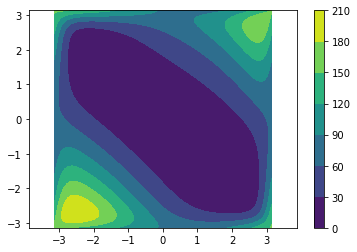

In [32]:
nx = 100 ; ny = 100
t1 = linspace(-pi,pi, nx)
t2 = linspace(-pi,pi, ny)

x1 = linspace(0.,1., nx)
x2 = linspace(0.,1., ny)
e_a = zeros((nx, ny), order='F')
e_m = zeros((nx, ny), order='F')
symbol_a2(x1,x2,t1,t2, e_a)
symbol_m(x1,x2,t1,t2, e_m)
e = e_a/e_m
e = e / (4 * pi**2)

T1,T2 = meshgrid(t1,t2)
plt.contourf(T1, T2, e)
plt.axis("equal")
plt.colorbar();

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()